In [1]:
import talib
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import date
import bt 

ticker = "BTC-USD"
today = date.today().strftime("%Y-%m-%d")
stock_data = yf.download(ticker, start="2020-1-1", end=today)


[*********************100%***********************]  1 of 1 completed


In [2]:
stock_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-22,19172.380859,19248.068359,19132.244141,19208.189453,19208.189453,16104440957
2022-10-23,19207.734375,19646.652344,19124.197266,19567.007812,19567.007812,22128794335
2022-10-24,19567.769531,19589.125000,19206.324219,19345.572266,19345.572266,30202235805
2022-10-25,19344.964844,20348.412109,19261.447266,20095.857422,20095.857422,47761524910
2022-10-26,20092.236328,20938.134766,20076.117188,20770.441406,20770.441406,58895950537


In [3]:
EMA_short = talib.EMA(stock_data['Close'], timeperiod=12).to_frame()
EMA_short = EMA_short.rename(columns={0: 'Close'})
EMA_long = talib.EMA(stock_data['Close'], timeperiod=50).to_frame()
EMA_long = EMA_long.rename(columns={0: 'Close'})

In [4]:
signal = EMA_long.copy()
signal[EMA_long.isnull()] = 0
signal[EMA_short > EMA_long] = 1
signal[EMA_short < EMA_long] = -1

In [5]:
signal[50:250]

,Close
Date,
2020-02-20,1.0
2020-02-21,1.0
2020-02-22,1.0
2020-02-23,1.0
2020-02-24,1.0
...,...
2020-09-02,1.0
2020-09-03,1.0
2020-09-04,1.0


In [6]:
transition = signal[signal['Close'].diff() != 0]
buy_signal = transition[transition['Close'] == 1]
sell_signal = transition[transition['Close'] == -1]

buy_index = buy_signal.index
buy_position = stock_data[stock_data.index.isin(buy_index)]
sell_index = sell_signal.index
sell_position = stock_data[stock_data.index.isin(sell_index)]

fig = go.Figure()
fig.add_trace(
        go.Candlestick(x=stock_data.index,
                        open=stock_data['Open'],
                        high=stock_data['High'],
                        low=stock_data['Low'],
                        close=stock_data['Close'],
                        name="Stock Prices"
                      )              
)

fig.add_trace(
        go.Scatter(
            x=stock_data.index,
            y=EMA_long['Close'],
            name="EMA 50"
        )
)

fig.add_trace(
        go.Scatter(
            x=stock_data.index,
            y=EMA_short['Close'],
            name = "EMA 12"
        )
)

fig.add_trace(
        go.Scatter(
            x=buy_position.index,
            y=buy_position['Close'], 
            name="Buy Signal",
            marker=dict(color="#511CFB", size=15),
            mode="markers",
            marker_symbol="triangle-up"
        )
)

fig.add_trace(
        go.Scatter(
            x=sell_position.index,
            y=sell_position['Close'], 
            name="Sell Signal",
            marker=dict(color="#750086", size=15),
            mode="markers",
            marker_symbol="triangle-down"
        )
)

fig.update_layout(
    xaxis_rangeslider_visible=False,
    title="Daily Close (" + ticker + ") Prices",
    xaxis_title="Date",
    yaxis_title="Price (USD)"
)
fig.show()

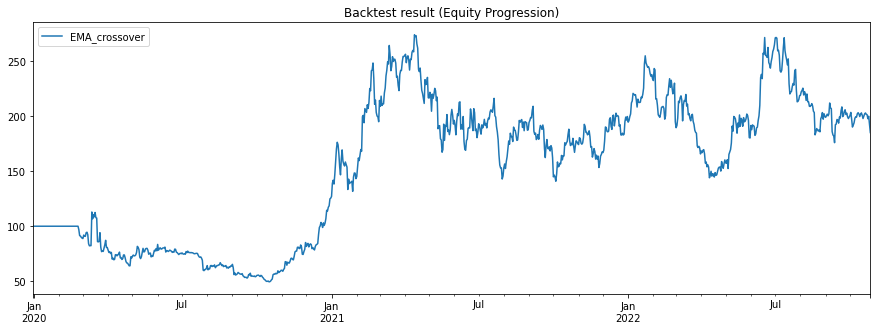

In [7]:
%matplotlib inline

bt_strategy = bt.Strategy('EMA_crossover',
                            [   bt.algos.RunWeekly(),
                                bt.algos.WeighTarget(signal),
                                bt.algos.Rebalance()
                            ]
                         )

bt_backtest = bt.Backtest(bt_strategy, stock_data['Close'].to_frame())
bt_result = bt.run(bt_backtest)
bt_result.plot(title='Backtest result (Equity Progression)')
plt.show()


Text(0.5, 0.98, 'weekly Return Histogram Matrix')

<Figure size 432x288 with 0 Axes>

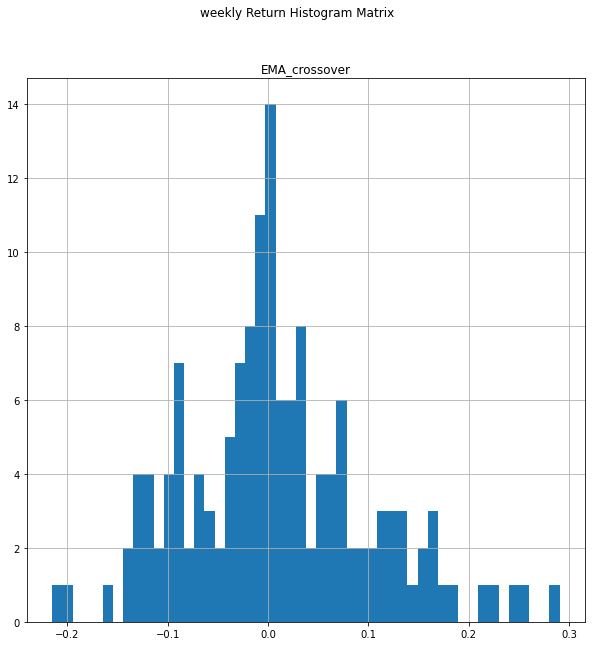

In [8]:
bt_result.plot_histograms(bins=50, freq = 'w')

In [10]:
bt_result.display()

Stat                 EMA_crossover
-------------------  ---------------
Start                2019-12-31
End                  2022-10-26
Risk-free rate       0.00%

Total Return         85.07%
Daily Sharpe         0.55
Daily Sortino        0.93
CAGR                 24.39%
Max Drawdown         -56.17%
Calmar Ratio         0.43

MTD                  -7.13%
3m                   -23.64%
6m                   16.60%
YTD                  -7.29%
1Y                   7.38%
3Y (ann.)            24.39%
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  24.39%

Daily Sharpe         0.55
Daily Sortino        0.93
Daily Mean (ann.)    32.60%
Daily Vol (ann.)     59.60%
Daily Skew           0.75
Daily Kurt           11.48
Best Day             37.14%
Worst Day            -19.95%

Monthly Sharpe       0.62
Monthly Sortino      1.75
Monthly Mean (ann.)  42.28%
Monthly Vol (ann.)   68.63%
Monthly Skew         0.91
Monthly Kurt         -0.19
Best Month           47.32%
Worst Month          